# Predicting Airbnb nightly price from property and host data

Authors: Tomas Beuzen, Florencia D'Andrea, Mds Octocat and Tiffany Timbers

In [1]:
options(repr.matrix.max.rows = 6)
set.seed(2022)
library(cowplot)
library(tidymodels)
library(tidyverse)
library(vroom)

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.10     ✔ recipes      0.1.17
✔ dials        0.0.10     ✔ rsample      0.1.0 
✔ dplyr        1.0.7      ✔ tibble       3.1.6 
✔ ggplot2      3.3.5      ✔ tidyr        1.1.4 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.4 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag(

## Summary

Here we attempt to build a regression model, using the k-nearest neighbors algorithm, which uses characteristics of an Airbnb property and host (price, bedrooms, host response rate, etc.) to predict the nightly price of the property. This model could help prospective and exisiting hosts determine how to price their new or existing property.

## Introduction

The data we will be using to build our model contains all the active Airbnb listings for Vancouver, Canada. The data set comes from Inside Airbnb and is updated monthly - we'll be using the a recent version of the data from April 2021.

The data set comprises 74 features. We'll be loading only a subset of features we believe to be relevant for this analysis, but more detailed EDA and evaluation could be used to determine exactly which of those 74 features would be useful in our model. The features we'll be looking at are:

- The host response rate (`host_response_rate`);
- The host acceptance rate (`host_acceptance_rate`);
- The property location (`latitude` and `longitude`);
- Number of bedrooms, number of beds, and number of guests the property accommodates (`bedrooms`, `beds` and `accommodates`);
- The minimum number of nights a guests must stay (`minimum_nights`); and,
- The review score of the property and number of reviews (`review_scores_rating`).
- The target variable we wish to predict is the property's nightly price (`price`). This is a number greater than 0.

In [2]:
url <- "http://data.insideairbnb.com/canada/bc/vancouver/2021-04-12/data/listings.csv.gz"
use_cols <- c("host_response_rate", "host_acceptance_rate", "latitude", 
              "longitude", "bedrooms", "beds", "minimum_nights", "accommodates", 
              "price", "review_scores_rating", "number_of_reviews")
listings <- vroom(url, col_select = use_cols)
write_csv(listings, "../data/raw/listings.csv")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(use_cols)` instead of `use_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Rows: 4299 Columns: 11

── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): host_response_rate, host_acceptance_rate, price
dbl (8): latitude, longitude, accommodates, bedrooms, beds, minimum_nights, ...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
listings

host_response_rate,host_acceptance_rate,latitude,longitude,bedrooms,beds,minimum_nights,accommodates,price,review_scores_rating,number_of_reviews
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
93%,87%,49.28872,-123.1205,2,2,90,5,$150.00,93,16
100%,57%,49.28201,-123.1267,1,1,30,2,$85.00,93,430
100%,78%,49.25622,-123.0661,1,1,30,2,$145.00,98,88
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
N/A,N/A,49.28631,-123.1245,1,NA,60,2,$160.00,NA,0
100%,100%,49.28822,-123.1306,1,1,31,1,$66.00,NA,0
97%,53%,49.27849,-123.1256,NA,0,30,2,$73.00,NA,0


### Pre-processing
We need to do some minor pre-processing to the data before we can build our predictive model. We will:

- Only look at properties with at least 1 `number_of_reviews`;
- Drop rows with one of more `NA` entries;
- Remove the "\%" from the `host_response_rate` and `host_acceptance_rate` columns; and,
- Remove the "$" from the `price` column.

In [4]:
listings <- listings |> 
  filter(number_of_reviews >= 1) |> 
  drop_na() |> 
  mutate(host_response_rate = str_remove(host_response_rate, "[%]") |> as.numeric(),
         host_acceptance_rate = str_remove(host_acceptance_rate, "[%]") |> as.numeric(),
         price = str_remove(price, "[$]") |> as.numeric()) 

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [5]:
listings_split <- initial_split(listings, prop = 0.8, strata = price)
listings_train <- training(listings_split)
listings_test <- testing(listings_split)

write_csv(listings_train, "../data/processed/listings_train.csv")
write_csv(listings_test, "../data/processed/listings_test.csv")

listings_train_summary <- listings_train |> 
    summarize(median_price = median(price, na.rm = TRUE),
             mean_price = mean(price, na.rm = TRUE),
             standard_deviation_price = sd(price, na.rm = TRUE))

listings_test_summary <- listings_test |> 
    summarize(median_price = median(price, na.rm = TRUE),
             mean_price = mean(price, na.rm = TRUE),
             standard_deviation_price = sd(price, na.rm = TRUE))

bind_rows(listings_train_summary, listings_test_summary) |>
    mutate(partition = c("Train", "Test"),
           fraction = c(0.8, 0.2))|> 
    relocate(partition, fraction)

partition,fraction,median_price,mean_price,standard_deviation_price
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Train,0.8,119,148.1376,110.6768
Test,0.2,119,147.4167,109.2699


We can see that some bassic summary statistics of the training and testing sets are similar.

## Exploratory data analysis

We want to determine which of our features is important for predicting the response variable price. To this end, we'll create scatter plots of each of the features with the response price and fit a regression line.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 726 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 726 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 622 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 622 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

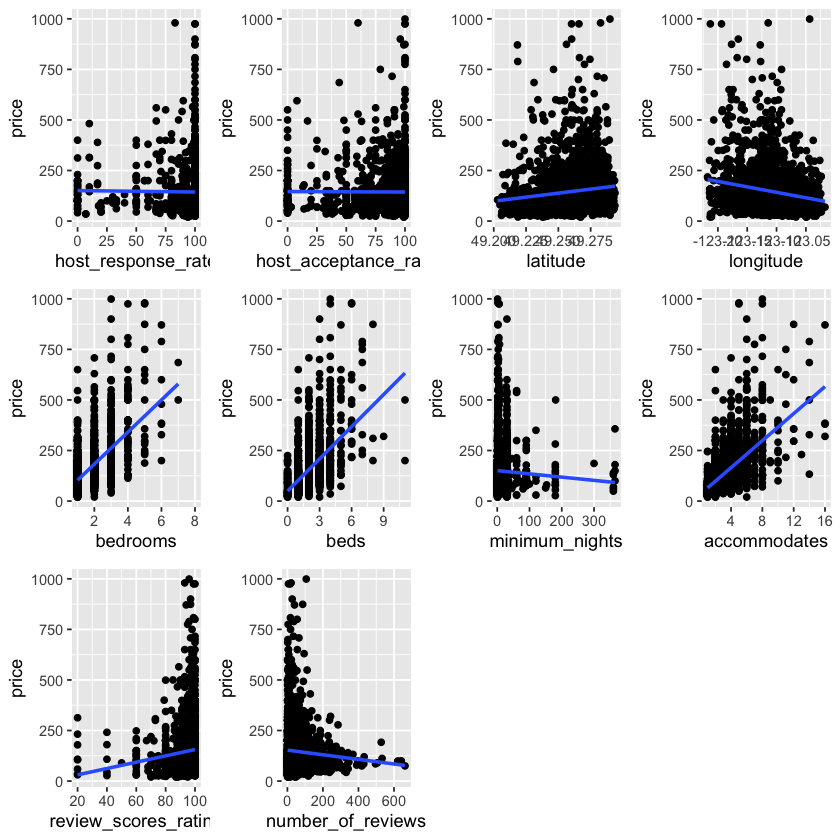

In [6]:
scatter_host_response_rate <- ggplot(listings_train, aes(x = host_response_rate, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_host_acceptance_rate <- ggplot(listings_train, aes(x = host_acceptance_rate, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_latitude <- ggplot(listings_train, aes(x = latitude, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_longitude <- ggplot(listings_train, aes(x = longitude, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_bedrooms <- ggplot(listings_train, aes(x = bedrooms, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_beds <- ggplot(listings_train, aes(x = beds, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_minimum_nights <- ggplot(listings_train, aes(x = minimum_nights, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_accommodates <- ggplot(listings_train, aes(x = accommodates, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_review_scores_rating <- ggplot(listings_train, aes(x = review_scores_rating, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_number_of_reviews <- ggplot(listings_train, aes(x = number_of_reviews, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

plot_grid(scatter_host_response_rate,
         scatter_host_acceptance_rate,
         scatter_latitude,
         scatter_longitude,
         scatter_bedrooms,
         scatter_beds,
         scatter_minimum_nights,
         scatter_accommodates,
         scatter_review_scores_rating,
         scatter_number_of_reviews)

The features `host_response_rate`, `host_acceptance_rate` don't seem to be strongly correlated with the target, `price` based on the above regression plots. We'll choose to drop these in our subsequent modelling.

## Modelling

We will use k-nearest neighbors regression to predict Airbnb nightly prices from our features. To find the best value of the parameter k (number of nearest neighbours), we will perform 10-fold cross validation using RMSPE as our metric of model prediction performance.

Note that our input features are on different scales, e.g., latitude is in degrees and number of bedrooms is an integer. To allow our k-nearest neighbors model to equally weight features, we should scale the data before training.

In [7]:
listings_recipe <- recipe(price ~ latitude + 
                          longitude + 
                          bedrooms + 
                          beds + 
                          minimum_nights + 
                          accommodates + 
                          review_scores_rating + 
                          number_of_reviews, 
                          data = listings_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

listings_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

listings_vfold <- vfold_cv(listings_train, v = 10, strata = price)

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

listings_tuning <- workflow() |>
  add_recipe(listings_recipe) |>
  add_model(listings_spec) |>
  tune_grid(resamples = listings_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

[1] 34

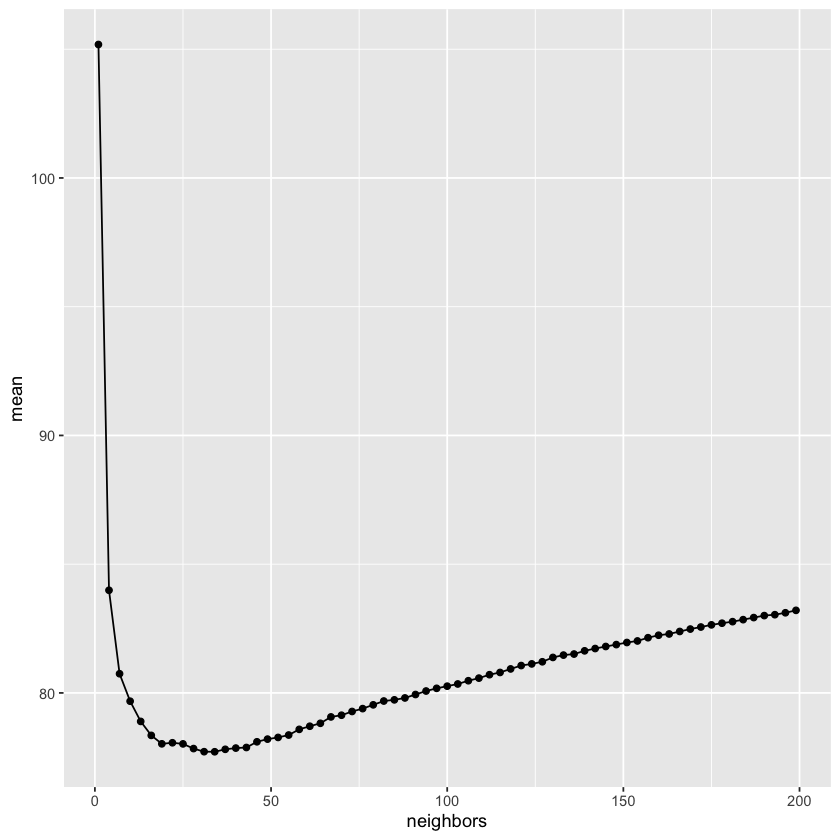

In [8]:
ggplot(listings_tuning, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

kmin <- listings_tuning |> 
    arrange(mean) |> 
    slice(1)|> 
    pull(neighbors)

kmin

The model has the lowest error at k=28 when using RMSPE as the model metric, thus we will use this to tune our final model.

In [9]:
listings_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

listings_fit <- workflow() |>
  add_recipe(listings_recipe) |>
  add_model(listings_spec) |>
  fit(data = listings_train)

listings_summary <- listings_fit |>
  predict(listings_test) |>
  bind_cols(listings_test) |>
  metrics(truth = price, estimate = .pred) |>
  filter(.metric == 'rmse')

listings_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,74.07366


We see that the test performance is similar to the cross-validation performance from earlier. Our result indicates that our model has an mean absolute error of about $70 per night which is not too bad... At this point, our model can provide Airbnb hosts with an estimate of how they should price their property, but it could be improved by collecting more data, or doing more intensive feature exploration and engineering.